In [1]:
from rpart.DecisionTreeClassifier import DecisionTreeClassifier
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
adult = pd.read_csv('data/adult.csv')
X = adult.drop('income', axis=1)
y = adult['income']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Create and train the DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5, metric='gini')
clf.fit(X_train, y_train)

In [6]:
from sklearn.metrics import accuracy_score, classification_report
# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.853618589415498
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.96      0.91      7429
        >50K       0.79      0.52      0.63      2340

    accuracy                           0.85      9769
   macro avg       0.83      0.74      0.77      9769
weighted avg       0.85      0.85      0.84      9769



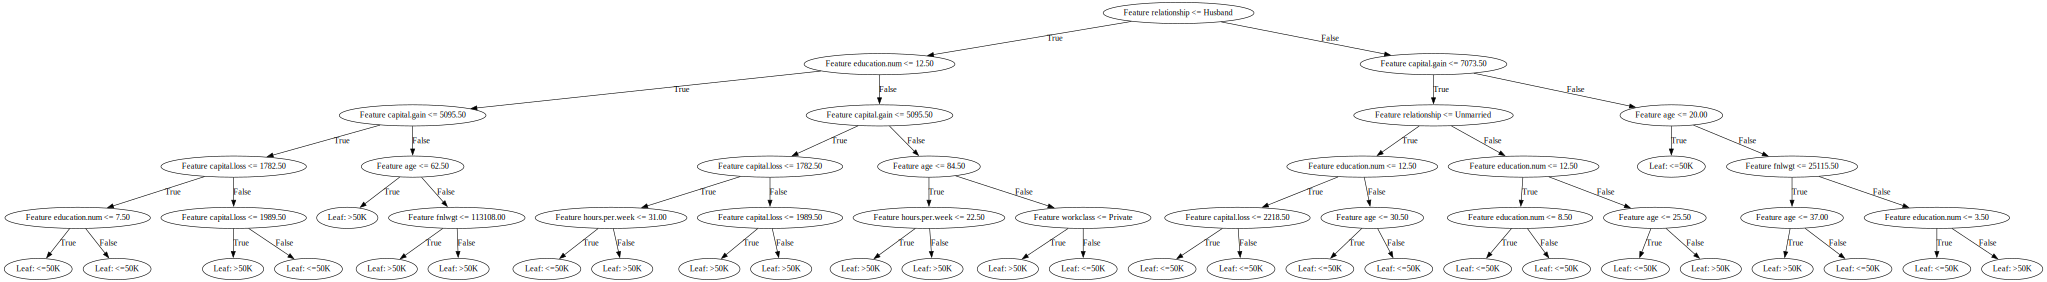

In [7]:
clf.draw()